## Overview
In this project, I've engineered an adaptive machine learning algorithm that undergoes biannual recalibration to select the most accurate model for sector-based investment strategies. To counteract the pitfalls of over-forecasting, the algorithm employs a custom loss function that penalizes overpredictions. It comprehensively integrates a diverse range of financial indicators, including equity, debt, commodities, and market volatility. To enhance computational efficiency and model precision, I employed Principal Component Analysis for feature reduction. The model's robustness was substantiated through a 15-year backtest, during which it outperformed the SPY index by an estimated 91.85%. The finalized, vetted model has been encapsulated in a real-time dashboard.

## Business Understanding: Adaptive Sector Selection
Current investment models are hampered by their inability to adapt swiftly to market changes, making them less predictive and more risky. This maladaptation is a significant drawback, as today's markets are influenced by a myriad of dynamic factors, from tech advances to geopolitical shifts.

Risk management, often sidelined, is crucial for portfolio resilience, especially in volatile markets. Without rigorous risk metrics, even sophisticated models can fail, jeopardizing significant investments.

Lastly, the Efficient-Market Hypothesis (EMH), though foundational, is increasingly scrutinized. It assumes a static, fully rational market, ignoring behavioral factors and information fluidity that can create exploitable inefficiencies. 

This project attempts to mitigate such limitations by employing a machine learning-driven "model of models" framework. This ensemble of algorithms undergoes biannual retraining and evaluation. The best-performing model is then selected for the next six-month cycle, ensuring the investment strategy continually adapts to current market conditions.

Once the leading model is identified, it selects the investment sector based on its predicted mean returns, specifically targeting the sector forecasted to yield the highest return. This dynamic, model-driven sector selection aims to optimize investment outcomes by leveraging timely and precise machine learning predictions.

The strategy is then tested via a 15-year backtest, offering empirical validation of its sector-based approach. Thus, the framework's utility manifests in its ability to not only adapt to market vicissitudes but also pinpoint the most promising sectors for investment based on forecasts.

---

## 2. Modeling & Optimization
This notebook goes through the process of modeling:
1. [Custom Error Function: Over-Under Error](#custom-error-function-over-under-error)
2. [The Nature of Walk Forward Cross-Validation and Training](#the-nature-of-walk-forward-cross-validation-and-training)
3. ["Model of Models" Architecture](#model-of-models-architecture)
4. [Models Used](#models-used)
5. [Modeling](#modeling)
    - [The Use of PCA](#the-use-of-pca)
    - [Naive Model](#naive-model)
    - [`ARIMAX` Model](#arimax-model)
    - [`sklearn` Models & `XGBoost`](#sklearn-models--xgboost)
    - [Comparison with the Naive Model](#comparison-with-the-naive-model)
    - [Results](#results)
6. [Portfolio Optimization](#portfolio-optimization)

The below are the necessary imports and file read-ins.

In [41]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom modules and functions
from workflow.tools.model_selection import (
    overunder_error, 
    naive_cross_val_score, 
    arimax_cross_val_score,
    ts_cross_val_score
)

# Misc. utility functions
from workflow.tools.utils import (
    read_file, 
    get_sectors, 
    set_plot_style
)

# SARIMAX model from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# sklearn models
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor
)
from sklearn.svm import SVR

# XGBoost
from xgboost import XGBRegressor

# Portfolio optimization models and misc. portfolio functions
from workflow.tools.portfolio.optimize import (
    max_sharpe_opt, 
    min_var_opt, 
    risk_parity_opt, 
    port_sharpe
)

from workflow.tools.portfolio.prune import prune_allocations

# Progres bar for loops
from tqdm.auto import tqdm

# Ignore warnings
from warnings import filterwarnings
filterwarnings("ignore")

set_plot_style()

stocks_by_sector = read_file("stocks_by_sector", index_col=0)
snp_log_returns = read_file("snp_log_returns", index_col=0)

In [2]:
stocks_by_sector.head()

,Symbol,GICS Sector
0,MMM,INDUSTRIALS
1,AOS,INDUSTRIALS
2,ABT,HEALTH_CARE
3,ABBV,HEALTH_CARE
4,ACN,INFORMATION_TECHNOLOGY


In [3]:
snp_log_returns.tail()

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-05,-0.026431,-0.026226,0.001266,-0.019340,-0.015046,-0.004833,0.002961,-0.004891,-0.011471,-0.011404,...,-0.018205,-0.025670,-0.042508,-0.016414,0.000088,-0.021303,-0.007433,-0.013825,-0.009833,-0.008543
2023-09-06,-0.006676,0.002096,-0.036450,0.006718,0.007617,0.000429,-0.005218,0.003519,-0.018166,-0.007144,...,0.002055,0.014617,-0.016353,0.013401,0.008595,0.000273,-0.014087,0.040425,-0.003189,-0.036932
2023-09-07,-0.014347,-0.023298,-0.029686,-0.008802,0.018535,0.005806,-0.002637,-0.020631,0.013719,0.001280,...,-0.003330,0.001851,-0.014399,0.004604,-0.004902,-0.014823,0.002440,-0.017765,-0.030340,-0.027958
2023-09-08,-0.019718,-0.001430,0.003486,0.000596,-0.007864,-0.008353,-0.000179,-0.005563,0.003559,-0.003003,...,-0.005115,-0.010844,0.002643,0.008270,0.014463,-0.004435,-0.005203,0.001161,-0.030236,0.030825
2023-09-11,-0.007838,0.007838,0.006601,0.016931,0.019737,0.001228,0.007361,0.001014,-0.000889,-0.004703,...,-0.001233,-0.001871,0.006420,0.006288,-0.012621,0.015709,0.001658,0.014727,-0.006261,-0.005456


### Custom Error Function: Over-Under Error

The Over-Under Error (OUE) calculates a loss based on the differences between true and predicted portfolio values. It is given by the formula:

$$\text{loss} = 
\begin{cases} 
\text{underpred penalty} \times \left| \text{residual} \right|^\alpha & \text{if residual} < 0 \\
\text{overpred penalty} \times \left| \text{residual} \right|^\alpha & \text{otherwise}
\end{cases}$$

Read below for the documentation or visit the [`workflow.tools.model_selection`](workflow/tools/model_selection.py) module for the source code.

In [4]:
help(overunder_error)

Help on function overunder_error in module workflow.tools.model_selection:

overunder_error(y_true, y_pred, underpred_penalty=1.0, overpred_penalty=1.0, alpha=0.5)
    Calculate the Over-Under Error for portfolio optimization.
    
    Parameters:
        y_true (array-like): True portfolio values.
        y_pred (array-like): Predicted portfolio values.
        underpred_penalty (float, optional): Penalty factor for underpredictions. Default is 1.0.
        overpred_penalty (float, optional): Penalty factor for overpredictions. Default is 1.0.
        alpha (float, optional): Exponent for residual calculation. Default is 0.5.
    
    Returns:
        float: Mean Over-Under Error.
    
    The Over-Under Error is a custom loss function written for portfolio optimization. It calculates a loss based on the 
    differences between true and predicted portfolio values. The function allows for penalties on overpredictions and 
    underpredictions using the 'overpred_penalty' and 'underpre

Though the function allows parametization of the overprediction penalty (`overpred_penalty`) and underprediction penalty (`underpred_penalty`), for the purposes of a long-only portfolio I've set `underpred_penalty = 0` and `overpred_penalty = 2`. This reflects a specific calculus, namely:

1. **Underprediction Tolerance**: In a long-only portfolio, underpredicting an asset's performance isn't inherently detrimental. If an asset outperforms your model's predictions, the consequence is a positive surprise. Hence, `underpred_penalty = 0`.
2. **Overprediction Risk**: Overestimating an asset's performance, however, can be more damaging in a long-only strategy. It may lead to an allocation that is disproportionately heavy in underperforming assets. This can hamper the portfolio's overall returns and increase its risk profile. Therefore, `overpred_penalty = 2` provides a stringent control mechanism for overoptimistic forecasts.
3. **Risk Aversion**: The higher overprediction penalty factor acts as a risk management tool, pushing the model toward conservative estimates and mitigating the impact of potential overallocations.
4. **Resource Allocation**: Penalizing overprediction guides the model to allocate resources more judiciously, reinforcing positions in assets that have a more reliable performance outlook.

That said, whether overpredicting or underpredicting is detrimental to the strategy is still contingent on one's specific risk tolerance, so feel free to play around with the parameters.

### The Nature of Walk Forward Cross-Validation and Training

Walk Forward Cross-Validation (WFCV) is a form of time-series cross-validation that simulates a realistic trading environment. Unlike traditional cross-validation methods which randomly partition data, walk-forward cross validation (WFCV) respects the temporal order of observations.

![Walk-Forward Cross Validation](workflow/img/wfcv.png)

WFCV can be "rolling" or "expanding". The picture above shows an expanding approach, where each testing window gets added to the subsequent training window; the training window thus "expands". In a rolling approach, the training window "rolls" forward, maintaining a fixed size. As new data points become available for testing, the earliest data points in the training set are removed to keep its size constant.

In this project I use the expanding approach, as the validation slice per time frame is small (126 days). The algorithm thus needs as much data as it can get from each time frame.

### "Model of Models" Architecture

The framework in this project employs a dynamic "Model of Models" architecture that re-trains each constituent model biannually, using data from the preceding six months. The model yielding the best Over-Under Error (OUE) score is selected as the lead model for the subsequent period. This chosen model identifies the most promising sector for investment based on the mean of its predicted returns. Stocks from the chosen sector are identified via their GICS segmentation.

### Models Used
The machine learning framework in this project comprises an ensemble of diverse models, each with distinct strengths tailored for financial market analysis. The models are preprocessed using Principal Component Analysis (PCA) to capture at least 80% of the variance in the data, and standard scaled for normalization. Below are the models and their configurations:

#### Regression Models
- **Elastic Net**: Combines L1 and L2 regularization, aiding in feature selection and handling multicollinearity.
    - Parameters: `alpha = 1` (strong regularization), `l1_ratio = 0.5` (balanced L1 and L2)
- **Support Vector (SVR)**: Uses an RBF kernel to capture non-linear relationships.
    - Parameters: `kernel = 'rbf'`, `c = 1` (moderate regularization), `gamma = 'auto'` (automatic kernal coefficient)
- **Random Forest**: An ensemble of decision trees, capturing complex relationships and feature importance.
    - Parameters: `n_estimators = 100`
- **Gradient Boosting**: Boosting algorithm suitable for capturing non-linear relationships.
    - Parameters: `n_estimators = 100`
- **Extreme Gradient Boosting**: Optimized gradient boosting algorithm known for speed and performance
    - Parameters: `n_estimators = 100`

All regression models are configured with `random_state = 42` for reproducibility. 

#### Time Series Models
- **Naïve**: Forecasts future returns based on the past six months of returns. Serves as a benchmark for performance.
- **ARIMAX**: Time series model that incorporates external variables to forecast future returns.

This ensemble enables the framework to adapt to a variety of market conditions, making it robust and versatile. The biannual recalibration process assesses the performance of these models, selecting the most effective one for the upcoming period.

### Model of Models
The framework employs a dynamic "Model of Models" architecture that re-trains each constituent model biannually, using data from the preceding six months. The model yielding the best Over-Under Error (OUE) score is selected as the lead model for the subsequent period. This chosen model identifies the most promising sector for investment based on the mean of its predicted returns. Stocks from the chosen sector are identified via their GICS segmentation. The resulting table is as such:

<p align="center">
    <img src="workflow/img/model_sector_results.png" alt="Results" width="65%" height="65%">
</p>

Following this, stock allocations are optimized based on mean-variance optimization methods, specifically the Maximum Sharpe Ratio, Risk Parity, and Minimum Variance optimizations. This cyclical recalibration ensures that the models and subsequently the investor's historical portfolio are updated with prevailing market conditions, optimizing both sector selection (via machine learning) and intra-sector asset allocation (via mean variance optimization).

### Modeling

Before we get to modeling, we'll need to load in `master_df.csv` from `data`, after which we'll separate it out into it features and targets.

In [5]:
# Load in files
sectors = get_sectors()
df = read_file("master_df", index_col=0)

# Separate `df` into features and targets
y_all = df[sectors]
X = df[df.columns[~df.columns.isin(sectors)]]

X.shape, y_all.shape

((4247, 109), (4247, 11))

#### Naive Model

We'll start with our naive model. This model uses the past 6 months of returns *as* the forecasted returns and will serve as a baseline upon which we can assess the efficacy of the more sophisticated models. 

Below is the cross-validation function for the naive model. Visit the [`workflow.tools.model_selection`](workflow/tools/model_selection.py) module to see the source code.

In [6]:
help(naive_cross_val_score)

Help on function naive_cross_val_score in module workflow.tools.model_selection:

naive_cross_val_score(r_true: pandas.core.series.Series, r_hat: pandas.core.series.Series, cv: int, scorer: Callable, **scorer_kwargs: Optional[Any]) -> List[float]
    Perform time-series cross-validation using a naive forecast model.
    
    Parameters:
        - r_true (Series): Actual target values.
        - r_hat (Series): Predicted target values.
        - cv (int): Number of splits/folds for time-series cross-validation.
        - scorer (Callable): Scoring function to evaluate the predictions. 
                             Must take two arrays 'y_true' and 'y_pred' as arguments,
                             along with any additional keyword arguments (**scorer_kwargs).
        - **scorer_kwargs (Optional[Any]): Additional keyword arguments to pass to the scoring function.
    
    Returns:
        - cv_scores (List[float]): List of scores calculated for each fold during cross-validation.
    
  

In [7]:
# Define the forecast horizon in terms of trading days per year
trading_days = 252
forecast = int(trading_days / 2)

In [8]:
# Define the forecast horizon in terms of trading days per year
trading_days = 252
forecast = int(trading_days / 2)

# Shift returns for forecasting, align indices
returns_shifted = y_all.shift(forecast).dropna()
returns_reind = y_all.reindex(returns_shifted.index)

# Initialize output DataFrames
naive_oues = pd.DataFrame()
naive_preds = pd.DataFrame()

# Loop through sectors
for sector in sectors:
    r_trues = returns_reind[sector]
    r_hats = returns_shifted[sector]
    
    # Time-chunk loop
    for i in range(forecast + 1, len(returns_reind), forecast):
        r_hat = r_hats.iloc[i-forecast:i]
        r_true = r_trues.iloc[i-forecast:i]
        
        # Calculate and store mean over-under loss
        mean_oul = np.mean(
            naive_cross_val_score(
                r_true, r_hat, cv=2, scorer=overunder_error,
                overpred_penalty=2, underpred_penalty=0
            )
        )

        naive_oues.loc[r_hat.index.max(), sector] = mean_oul
        naive_preds.loc[r_hat.index.max(), sector] = np.mean(r_hat)

In [9]:
# Take the mean Over-Under Error (OUE) across sectors
mean_naive_oues = pd.DataFrame(naive_oues.mean(axis=1), columns=["Naive"])
mean_naive_oues.tail()

,Naive
2021-05-27,0.112564
2021-11-24,0.089520
2022-05-26,0.114221
2022-11-25,0.126207
2023-05-30,0.114620


In [10]:
# Take the sector with the highest predicted mean return
naive_sectors = pd.DataFrame(naive_preds.idxmax(axis=1), columns=["Naive"])
naive_sectors.tail()

,Naive
2021-05-27,MATERIALS
2021-11-24,ENERGY
2022-05-26,ENERGY
2022-11-25,ENERGY
2023-05-30,INDUSTRIALS


#### `ARIMAX` Model

Now that we have a baseline to compare to, we'll begin with our ARIMAX model. ARIMA (AutoRegressive Integrated Moving Average) is a time-series forecasting model that uses past observations and their lags to predict future points. ARIMAX extends ARIMA by incorporating external (X) variables, allowing the model to capture additional influencing factors not present in the time-series itself. Learn more about ARIMAX [here](https://www.smarten.com/blog/arimax-forecasting-enterprise-analysis/#:~:text=An%20Autoregressive%20Integrated%20Moving%20Average,moving%20average%20(MA)%20terms.).

Below is the cross-validation function for the ARIMAX model. Visit the [`workflow.tools.model_selection`](workflow/tools/model_selection.py) module to see the source code.

In [11]:
help(arimax_cross_val_score)

Help on function arimax_cross_val_score in module workflow.tools.model_selection:

arimax_cross_val_score(X: pandas.core.frame.DataFrame, y: pandas.core.series.Series, order: Tuple[int, int, int], pca: sklearn.pipeline.Pipeline, cv: int, scorer: Callable, **scorer_kwargs: Optional[Any]) -> List[float]
    Perform time-series cross-validation using an ARIMA model with exogenous variables and PCA.
    
    Parameters:
        - X (DataFrame): Feature matrix.
        - y (Series): Target variable.
        - order (Tuple[int, int, int]): The (p,d,q) order of the model for the number of AR, differences, and MA parameters.
        - seasonal_order (Tuple[int, int, int, int]): The (P,D,Q,S) order of the seasonal component.
        - pca (Pipeline): PCA pipeline for dimensionality reduction.
        - cv (int): Number of folds in TimeSeriesSplit.
        - scorer (Callable): Custom scoring function.
        - **scorer_kwargs (Optional[Any]): Additional keyword arguments for the scoring functio

In [12]:
# Shift the features to match the forecast horizon, and drop any missing values
X_shifted = X.shift(forecast).dropna()

# Create a pipeline for standardizing and applying PCA
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=.8, random_state=42))

# Define the ARIMAX orders for ARIMA and seasonal components
order = (1, 0, 1) # Returns are usually stationary, so no differencing applied

# Initialize empty DataFrames to store predictions and over-under loss scores
arimax_preds = pd.DataFrame()
arimax_oues = pd.DataFrame()

# Loop through each sector
for sector in tqdm(sectors):

    # Extract the target variable for the current sector
    y = y_all[sector].reindex(X_shifted.index)

    # Loop through the data with a window equal to the forecast horizon
    for i in range(forecast, len(y), forecast):
        
        # Split the data into training and testing sets
        X_train, X_test = X_shifted.iloc[i-forecast:i], X_shifted.iloc[i:i+forecast]
        y_train, y_test = y[i-forecast:i], y[i:i+forecast]

        # Apply PCA to the training and testing feature sets
        X_train_pca = pca_pipe.fit_transform(X_train)
        X_test_pca = pca_pipe.transform(X_test)

        # Perform time-series cross-validation and calculate the mean over-under loss
        mean_oul = np.mean(
            arimax_cross_val_score(
                X_train,
                y_train,
                order=order,
                pca=pca_pipe,
                cv=2,
                scorer=overunder_error,
                overpred_penalty=2,
                underpred_penalty=0
            )
        )
        
        # Store the mean over-under loss score
        arimax_oues.loc[X_test.index.min(), sector] = mean_oul

        # Fit the ARIMAX model to the training data
        model = SARIMAX(y_train.values, X_train_pca, order=order).fit()

        # Generate forecasts for the testing data
        forecast_results = model.get_forecast(steps=len(X_test_pca), exog=X_test_pca)
        y_hat = forecast_results.predicted_mean

        # Store the mean forecasted value
        arimax_preds.loc[X_test.index.min(), sector] = np.mean(y_hat)

  0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
# Take the mean Over-Under Error (OUE) across sectors
mean_arimax_oues = pd.DataFrame(arimax_oues.mean(axis=1), columns=["ARIMAX"])
mean_arimax_oues.tail()

,ARIMAX
2021-05-27,0.104849
2021-11-24,0.093428
2022-05-26,0.113409
2022-11-25,0.089156
2023-05-30,0.085455


In [14]:
# Take the sector with the highest predicted mean return
arimax_sectors = pd.DataFrame(arimax_preds.idxmax(axis=1), columns=["ARIMAX"])
arimax_sectors.tail()

,ARIMAX
2021-05-27,ENERGY
2021-11-24,UTILITIES
2022-05-26,INFORMATION_TECHNOLOGY
2022-11-25,ENERGY
2023-05-30,COMMUNICATION_SERVICES


#### `sklearn` Models & `XGBoost`

Next, we utilize `sklearn` models and `XGBoost`, a repertoire distinct from ARIMAX, to address our time-series problem. These machine learning algorithms, such as ElasticNet, SVR, RandomForest, GradientBoost, and XGBoost, offer a more flexible approach to capturing complex, non-linear relationships in stock returns. Unlike ARIMAX, which relies solely on the historical patterns and external variables, these models can handle a wider variety of features and are often better at capturing non-linearities and interactions among variables.

I also employ `XGBoost`, a gradient boosting framework known for its efficiency and performance. Unlike ARIMAX, which assumes a specific functional form for the time-series data, `XGBoost` is non-parametric, making it more adaptable to various data structures. This flexibility allows it to effectively capture intricate patterns in stock returns that simpler models might miss.

In this phase of modeling, there are two steps:
1) Start off with the base parameters as per the default instantiation of the models.
2) Deploy tuned* models and compare with base.

I've clumped these up together because they fit neatly into `sklearn`'s pipeline functionality.

Below is the cross-validation function for the `sklearn` models and `XGBoost` model. Visit the [`workflow.tools.model_selection`](workflow/tools/model_selection.py) module to see the source code.

**Because of the limitations of computational power, I've opted out of using `GridSearchCV` and the like to tune model hyperparameters. Instead, I use some domain intuition to manually set the hyperparameters.*

In [15]:
help(ts_cross_val_score)

Help on function ts_cross_val_score in module workflow.tools.model_selection:

ts_cross_val_score(model: sklearn.base.BaseEstimator, X: pandas.core.frame.DataFrame, y: pandas.core.series.Series, cv: int, scorer: Callable, **scorer_kwargs: Optional[Any]) -> List[float]
    Perform time-series cross-validation on a given model using a specific scoring function.
    
    Parameters:
    - model (BaseEstimator): The machine learning model to be trained and validated.
    - X_train (DataFrame): Feature matrix for the training data.
    - y_train (Series): Target vector for the training data.
    - cv (int): Number of splits/folds for cross-validation.
    - scorer (Callable): Scoring function to evaluate the predictions. Must take two arrays 
                         'y_true' and 'y_pred' as arguments, along with any additional 
                         keyword arguments (**scorer_kwargs).
    - **scorer_kwargs (Optional[Any]): Additional keyword arguments to pass to the scoring function.
 

Let's start with step 1:

In [16]:
scaler = StandardScaler()
pca = PCA(n_components=.8, random_state=42)

sklearn_models_base = {# Create a dictionary of regression models designed for working with stock returns
    # ElasticNet combines L1 and L2 regularization, suitable for feature selection and dealing with multicollinearity.
    'ElasticNet_B': make_pipeline(scaler, pca, ElasticNet(random_state=42)),
    
    # Support Vector Regressor (SVR) with an RBF kernel can capture non-linear relationships in stock returns.
    'SVR_B': make_pipeline(scaler, pca, SVR()),
    
    # RandomForestRegressor is an ensemble method that can capture complex relationships and feature importance.
    'RandomForest_B': make_pipeline(scaler, pca, RandomForestRegressor(random_state=42)),
    
    # GradientBoostingRegressor is another ensemble method suitable for capturing non-linear relationships and trends.
    'GradientBoost_B': make_pipeline(scaler, pca, GradientBoostingRegressor(random_state=42)),

    # XGBoostRegressor is an optimized gradient boosting algorithm known for its speed and performance.
    'XGBoost_B': make_pipeline(scaler, pca, XGBRegressor(random_state=42)),
}

In [17]:
# Initialize empty DataFrames to store model predictions and Over-Under loss (OUL)
preds_B = {model: pd.DataFrame() for model in sklearn_models_base.keys()}
oues_B = {model: pd.DataFrame() for model in sklearn_models_base.keys()}

# Loop through each sector in the target data
for sector in tqdm(y_all.columns):
    
    # Loop through each machine learning model
    for name, model in sklearn_models_base.items():

        # Copy the target data for the current sector
        y = y_all[sector].reindex(X_shifted.index)

        # Loop through the data in steps of 'forecast' days
        for i in range(forecast, len(y), forecast):
            
            # Split the data into rolling windows for training and testing
            X_train = X_shifted.iloc[i-forecast:i]
            X_test = X_shifted.iloc[i:i+forecast]
            y_train = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]

            # Conduct cross validation
            mean_oue = np.mean(
                ts_cross_val_score(
                    model, 
                    X_train, 
                    y_train, 
                    cv=2, 
                    scorer=overunder_error, 
                    underpred_penalty=0,
                    overpred_penalty=2
                )
            )
            
            # Take the mean of the OUEs
            oues_B[name].loc[X_test.index.min(), sector] = mean_oue

            # Fit the model on the full rolling training window and predict on the test set
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            # Store the mean of the predicted values (predicted logarithmic returns)
            preds_B[name].loc[X_test.index.min(), sector] = np.mean(y_hat)

        # Ensure predictions and oues to float type
        preds_B[name][sector] = preds_B[name][sector].astype(float)
        oues_B[name][sector] = oues_B[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

In [18]:
# Calculate the mean of each DataFrame in the 'ouls' dictionary along the rows
mean_sklearn_base_oues = {model: pd.Series(oue.mean(axis=1), name=model) for model, oue in oues_B.items()}

# Concatenate the mean Series from each model into a single DataFrame
mean_sklearn_base_oues = pd.concat([oul for oul in mean_sklearn_base_oues.values()], axis=1)
mean_sklearn_base_oues.tail()

,ElasticNet_B,SVR_B,RandomForest_B,GradientBoost_B,XGBoost_B
2021-05-27,0.090109,0.097493,0.087067,0.085022,0.087751
2021-11-24,0.082395,0.085389,0.095910,0.097937,0.105602
2022-05-26,0.105639,0.123202,0.108839,0.110993,0.118277
2022-11-25,0.114985,0.144654,0.112414,0.122114,0.128194
2023-05-30,0.085638,0.093689,0.080241,0.078798,0.085667


In [19]:
# Determine the sector with the maximum value across time
sklearn_base_sectors = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds_B.items()}

# Concatenate the Series from each model into a single DataFrame
sklearn_base_sectors = pd.concat([pred for pred in sklearn_base_sectors.values()], axis=1)
sklearn_base_sectors.tail()

,ElasticNet_B,SVR_B,RandomForest_B,GradientBoost_B,XGBoost_B
2021-05-27,ENERGY,MATERIALS,ENERGY,ENERGY,ENERGY
2021-11-24,ENERGY,ENERGY,INFORMATION_TECHNOLOGY,ENERGY,ENERGY
2022-05-26,ENERGY,UTILITIES,ENERGY,UTILITIES,UTILITIES
2022-11-25,INDUSTRIALS,INFORMATION_TECHNOLOGY,INDUSTRIALS,FINANCIALS,CONSUMER_DISCRETIONARY
2023-05-30,INFORMATION_TECHNOLOGY,UTILITIES,INFORMATION_TECHNOLOGY,INFORMATION_TECHNOLOGY,INFORMATION_TECHNOLOGY


In [20]:
sklearn_base_sectors.head()

,ElasticNet_B,SVR_B,RandomForest_B,GradientBoost_B,XGBoost_B
2007-11-20,ENERGY,INDUSTRIALS,INFORMATION_TECHNOLOGY,INFORMATION_TECHNOLOGY,COMMUNICATION_SERVICES
2008-05-22,ENERGY,CONSUMER_DISCRETIONARY,REAL_ESTATE,UTILITIES,UTILITIES
2008-11-19,CONSUMER_STAPLES,UTILITIES,UTILITIES,REAL_ESTATE,REAL_ESTATE
2009-05-22,CONSUMER_DISCRETIONARY,REAL_ESTATE,CONSUMER_DISCRETIONARY,REAL_ESTATE,REAL_ESTATE
2009-11-19,REAL_ESTATE,INDUSTRIALS,COMMUNICATION_SERVICES,COMMUNICATION_SERVICES,COMMUNICATION_SERVICES


Let's move on to step 2:

In [21]:
sklearn_tuned_models = {
    'ElasticNet_T': make_pipeline(scaler, pca, ElasticNet(alpha=1, l1_ratio=0.5, random_state=42)),
    'SVR_T': make_pipeline(scaler, pca, SVR(kernel='rbf', C=1, gamma='auto')),
    'RandomForest_T': make_pipeline(scaler, pca, RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42)),
    'GradientBoost_T': make_pipeline(scaler, pca, GradientBoostingRegressor(n_estimators=100, random_state=42)),
    'XGBoost_T': make_pipeline(scaler, pca, XGBRegressor(n_estimators=100, random_state=42)),
}

# Explanation for parameter choices:

# ElasticNet Parameters:
#   - alpha=1: Strong regularization to prevent overfitting.
#   - l1_ratio=0.5: Balanced mix of L1 (Lasso) and L2 (Ridge) regularization.
#   - random_state=42: Ensures reproducible results.

# SVR Parameters:
#   - kernel='rbf': RBF kernel to capture non-linear stock return relationships.
#   - C=1: Moderate regularization to control model complexity.
#   - gamma='auto': Automatic kernel coefficient selection based on data.

# RandomForestRegressor Parameters:
#   - n_estimators=100: 100 decision trees balance complexity and predictive power.
#   - max_depth=3: Shallow trees to prevent overfitting.
#   - random_state=42: Ensures reproducible ensemble results.

# GradientBoostingRegressor Parameters:
#   - n_estimators=100: 100 boosting stages capture complex relationships.
#   - random_state=42: Ensures reproducible ensemble results.

# XGBoostRegressor Parameters:
#   - n_estimators=100: 100 boosting rounds balance performance and efficiency.
#   - random_state=42: Ensures reproducible results with XGBoost.

In [22]:
# Initialize empty DataFrames to store model predictions and Over-Under loss (OUL)
preds_T = {model: pd.DataFrame() for model in sklearn_tuned_models.keys()}
oues_T = {model: pd.DataFrame() for model in sklearn_tuned_models.keys()}

# Loop through each sector in the target data
for sector in tqdm(y_all.columns):
    
    # Loop through each machine learning model
    for name, model in sklearn_tuned_models.items():

        # Copy the target data for the current sector
        y = y_all[sector].reindex(X_shifted.index)

        # Loop through the data in steps of 'forecast' days
        for i in range(forecast, len(y), forecast):
            
            # Split the data into rolling windows for training and testing
            X_train = X_shifted.iloc[i-forecast:i]
            X_test = X_shifted.iloc[i:i+forecast]
            y_train = y.iloc[i-forecast:i]
            y_test = y.iloc[i:i+forecast]

            # Conduct cross validation
            mean_oue = np.mean(
                ts_cross_val_score(
                    model, 
                    X_train, 
                    y_train, 
                    cv=2, 
                    scorer=overunder_error, 
                    underpred_penalty=0,
                    overpred_penalty=2
                )
            )
            
            # Take the mean of the OUEs
            oues_T[name].loc[X_test.index.min(), sector] = mean_oue

            # Fit the model on the full rolling training window and predict on the test set
            model.fit(X_train, y_train)
            y_hat = model.predict(X_test)
            
            # Store the mean of the predicted values (predicted logarithmic returns)
            preds_T[name].loc[X_test.index.min(), sector] = np.mean(y_hat)

        # Ensure predictions and ouls to float type
        preds_T[name][sector] = preds_T[name][sector].astype(float)
        oues_T[name][sector] = oues_T[name][sector].astype(float)

  0%|          | 0/11 [00:00<?, ?it/s]

In [23]:
# Calculate the mean of each DataFrame in the 'ouls' dictionary along the rows
mean_sklearn_tuned_oues = {model: pd.Series(oue.mean(axis=1), name=model) for model, oue in oues_T.items()}

# Concatenate the mean Series from each model into a single DataFrame
mean_sklearn_tuned_oues = pd.concat([oul for oul in mean_sklearn_tuned_oues.values()], axis=1)
mean_sklearn_tuned_oues.tail()

,ElasticNet_T,SVR_T,RandomForest_T,GradientBoost_T,XGBoost_T
2021-05-27,0.090109,0.097493,0.089221,0.085022,0.087751
2021-11-24,0.082395,0.085389,0.093182,0.097937,0.105602
2022-05-26,0.105639,0.123202,0.109485,0.110993,0.118277
2022-11-25,0.114985,0.144654,0.109628,0.122114,0.128194
2023-05-30,0.085638,0.093689,0.081284,0.078798,0.085667


In [24]:
# Determine the sector with the maximum value across time
sklearn_tuned_sectors = {model: pd.Series(pred.idxmax(axis=1), name=model) for model, pred in preds_T.items()}

# Concatenate the Series from each model into a single DataFrame
sklearn_tuned_sectors = pd.concat([pred for pred in sklearn_tuned_sectors.values()], axis=1)

# Display the first few rows of the model_preds DataFrame
sklearn_tuned_sectors.tail()

,ElasticNet_T,SVR_T,RandomForest_T,GradientBoost_T,XGBoost_T
2021-05-27,ENERGY,MATERIALS,ENERGY,ENERGY,ENERGY
2021-11-24,ENERGY,ENERGY,INFORMATION_TECHNOLOGY,ENERGY,ENERGY
2022-05-26,ENERGY,UTILITIES,ENERGY,UTILITIES,UTILITIES
2022-11-25,INDUSTRIALS,INFORMATION_TECHNOLOGY,INDUSTRIALS,FINANCIALS,CONSUMER_DISCRETIONARY
2023-05-30,INFORMATION_TECHNOLOGY,UTILITIES,INFORMATION_TECHNOLOGY,INFORMATION_TECHNOLOGY,INFORMATION_TECHNOLOGY


It seems that, at least for the recent values of Over-Under Errors, the base versions of our models and the tuned models are not so different. However, you'll notice that not all base-tuned model pairs select the same sectors; i.e. they aren't predicting the same returns for the sectors. This opens up two pathways for us—we can:

1) Take the model with the minimum score across each period via `.idxmin(axis=1)` (python takes the first appearance and drops the subsequent id).
2) If both the base and tuned model performed the same, but have different selections of sectors, we invest in both sectors.

For the sake of concision and comprehension, I'll go for **option 2**, which offers a pragmatic advantage—it capitalizes on the collective wisdom of the base and tuned models. When these models exhibit similar Over-Under Errors but recommend different sectors, it may be indicator that each is capturing distinct facets of market behavior. By investing in both sectors, one not only diversifies one's risk but also maximizes one's opportunity for gains. This strategy effectively amalgamates the disparate insights of the models into a unified investment approach, making it a judicious choice contingent upon favorable backtesting results.


In [25]:
# Concatenate the OUEs (Out-of-Sample Unconditional Errors) of different models into a single DataFrame
all_oues = pd.concat([
    mean_naive_oues,  # Mean OUEs from the Naive model
    mean_arimax_oues,  # Mean OUEs from the ARIMAX model
    mean_sklearn_base_oues,  # Mean OUEs from the base sklearn models
    mean_sklearn_tuned_oues  # Mean OUEs from the tuned sklearn models
], axis=1)

# Determine the best models by finding the minimum OUE for each time period (row)
best_models = all_oues.apply(
    lambda row: [col for col, val in row.items() if val == row.min()], axis=1
)

best_models.tail()

2021-05-27    [GradientBoost_B, GradientBoost_T]
2021-11-24          [ElasticNet_B, ElasticNet_T]
2022-05-26          [ElasticNet_B, ElasticNet_T]
2022-11-25                              [ARIMAX]
2023-05-30    [GradientBoost_B, GradientBoost_T]
dtype: object

In [26]:
# Concatenate sector selections of different models into a single DataFrame
model_sectors = pd.concat([
    naive_sectors,  # Sectors selected by the Naive model
    arimax_sectors,  # Sectors selected by the ARIMAX model
    sklearn_base_sectors,  # Sectors selected by the base sklearn models
    sklearn_tuned_sectors  # Sectors selected by the tuned sklearn models
], axis=1)

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(
    columns=["SELECTED_MODELS", "SELECTED_SECTORS"],
    index=best_models.index  # Using the same index as best_models DataFrame
)

# Iterate over each date in the index of best_models
for date in best_models.index:

    # Initialize empty lists to store the selected models and sectors for each date
    results.loc[date, "SELECTED_MODELS"] = []
    results.loc[date, "SELECTED_SECTORS"] = []

    # For each model identified as best for a particular date,
    # append its name and the sector it selected to the results DataFrame
    for model in best_models.loc[date]:
        results.loc[date, "SELECTED_MODELS"].append(model)
        results.loc[date, "SELECTED_SECTORS"].append(model_sectors.loc[date, model])

In [27]:
# Filter the 'results' DataFrame to only include rows where the 
# "SELECTED_SECTORS" column has exactly 2 elements
filtered_results = results[results["SELECTED_SECTORS"].apply(lambda x: len(x) == 2)]

Interestingly, the data reveals a pattern of consensus between base models and their tuned counterparts (specifically for the best-performing models), particularly in sector selection.

In every instance, both versions recommend the same sector for investment. This uniformity in sector preference not only suggests that the additional tuning is not materially altering the models' fundamental insights into sectoral performance, but also serves as corroborative evidence that reinforces the confidence in the sector selection. Given this dual benefit of redundancy and validation, it may be judicious to drop one version—either the base or the tuned—in order to streamline the decision-making process without sacrificing the quality of sector recommendations. I'll use `.idxmin(axis=1)` to automatically take care of this.

This does, however, mean that we must forego investing in multiple sectors (and by extension, extensive diversification) as per the mandates of the framework. But since in this project the selection of the model based on its OUE takes precedence over heuristics-based sector selection, this approach will suffice. Additionally, that we recalibrate the models at every 126-day period end helps us "diversify" in the sense that there's always a regular rebalancing opportunity and a possibility of switching out our holdings altogether.

In [28]:
# Identify the model with the minimum OUE for each date, store in 'best_models_trimmed'
best_models_trimmed = all_oues.idxmin(axis=1)

# Create a new DataFrame 'results_new' based on the original 'results' DataFrame
results_new = results.copy()
# Rename the columns for clarity
results_new.columns = ["SELECTED_MODEL", "SELECTED_SECTOR"]

# Iterate over each date in the DataFrame index
for date in results_new.index:
    # Get the best model for the current date from 'best_models_trimmed'
    best_model = best_models_trimmed.loc[date]
    # Get the selected sector for the best model at the current date
    selected_sector = model_sectors.loc[date, best_model]
    # Update 'results_new' with the best model and its selected sector for the current date
    results_new.loc[date, "SELECTED_MODEL"] = best_model
    results_new.loc[date, "SELECTED_SECTOR"] = selected_sector

# Display the last few rows of the updated DataFrame
results_new.tail()

,SELECTED_MODEL,SELECTED_SECTOR
2021-05-27,GradientBoost_B,ENERGY
2021-11-24,ElasticNet_B,ENERGY
2022-05-26,ElasticNet_B,ENERGY
2022-11-25,ARIMAX,ENERGY
2023-05-30,GradientBoost_B,INFORMATION_TECHNOLOGY


We now have a cleaner version of our previous `results` dataframe. In this new version, we choose one model at the end of each 126-day period, and invest in the sector chosen at that that time by the model selected at that time. The last step of our modeling phase before we begin to optimize our allocations  is to compaer the models' performance to the naive forecast model.

#### Comparison with the Naive Model

In [29]:
# Find the first date where the 'Naive' model was the best
naive_best_date = results_new[results_new["SELECTED_MODEL"] == "Naive"].index[0].strftime("%Y-%m-%d")

naive_best_date

'2020-05-28'

It seems that the naive model outperformed another model just at one rebalancing period, namely May 28<sup>th</sup>, 2020. In the context of the Over-Under error, which penalizes overpredictions more heavily, the naïve model's superior performance suggests it made fewer and less severe overestimations on that specific date. This could be particularly valuable in a long-only investment strategy where overpredictions could lead to overexposure to risk. During this period, the market may have been in a state of equilibrium—a state of mean reversion—or following predictable cyclical trends, making the past a reliable predictor of the immediate future.

However, it is also telling that the naive model's outperformance only occured *once out of 32 periods*. This is far too unreliable for an investment strategy, where the welfare of the client matters most and more consistent models should be used. Thus, I deemed it too fickle for consistent inclusion in the ensemble and omitted it to focus on models that demonstrate more reliable performance across various market conditions. Let's see if which other model could take its stead:

In [30]:
# Concatenating the Over-Under Error (OUE) of models, excluding the Naive model
oues_sans_naive = pd.concat([
    mean_arimax_oues,
    mean_sklearn_base_oues,
    mean_sklearn_tuned_oues
], axis=1)

# Concatenating the sector selection of models, excluding the Naive model
model_sectors_sans_naive = pd.concat([
    arimax_sectors,
    sklearn_base_sectors,
    sklearn_tuned_sectors
], axis=1)

# Identifying the model with the minimum OUE for each date, without including the Naive model
best_model_sans_naive = oues_sans_naive.idxmin(axis=1)

# Making a copy of the original results DataFrame and renaming its columns
results_fin = results.copy()
results_fin.columns = ["SELECTED_MODEL", "SELECTED_SECTOR"]

# Looping through each date to populate the final results DataFrame with the best model and its selected sector
for date in results_fin.index:
    best_model = best_model_sans_naive.loc[date]
    selected_sector = model_sectors_sans_naive.loc[date, best_model]
    results_fin.loc[date, "SELECTED_MODEL"] = best_model
    results_fin.loc[date, "SELECTED_SECTOR"] = selected_sector

# Checking what model would be selected instead of the Naive model on its best-performing date
results_fin.loc[naive_best_date]["SELECTED_MODEL"]

'ElasticNet_B'

In [42]:
# Create a dataframe to showcase how frequently each model was chosen
# throughout the dataset
model_occurence = pd.DataFrame(
    results_fin["SELECTED_MODEL"].value_counts(),
)

model_occurence.columns = ["MODEL_OCCURENCE"]
model_occurence

,MODEL_OCCURENCE
ElasticNet_B,13
ARIMAX,6
SVR_B,4
GradientBoost_B,3
RandomForest_T,3
RandomForest_B,2
XGBoost_B,1


The `ElasticNet` base model would have taken the place of the Naive model. Since this model showed the most consistent performance over time, we'll use that in our historical backtest, in lieu of the naive model.

We now have to retrieve the available stocks per given sector selected by each model. However, note that we **do not have all the stocks available within the 503 S&P constituents**, meaning we have to trim the `stocks_by_sector` dataframe to only include stocks that are in the `snp_log_returns`. We need to do this so that we can parse the dataframes accordingly and discern the available stocks within the sectors recommended by the model-of-models framework.</s>

In [32]:
# Retrieve all the stock symbols from the 'stocks_by_sector' DataFrame
snp_consts = stocks_by_sector["Symbol"].values

# Get all stock symbols available in the 'snp_log_returns' DataFrame
available_stocks = snp_log_returns.columns

len(snp_consts), len(available_stocks)

(503, 419)

In [33]:
# Filter the 'stocks_by_sector' DataFrame to only include stocks that are also present in 'snp_log_returns'
stocks_by_sector_tr = stocks_by_sector[stocks_by_sector["Symbol"].isin(available_stocks)]

len(stocks_by_sector_tr)

419

In [34]:
# Initialize a new column "AVAILABLE_STOCKS" in the DataFrame 'results_fin' and set its values to NaN
results_fin["AVAILABLE_STOCKS"] = np.nan

# Loop through each date in the index of 'results_fin'
for date in results_fin.index:
    # Retrieve the sector selected by the model for the given date
    sector = results_fin.loc[date, "SELECTED_SECTOR"]
    # Get the list of stocks available in that sector from the trimmed 'stocks_by_sector_tr' DataFrame
    stocks = stocks_by_sector_tr[stocks_by_sector_tr["GICS Sector"] == sector]["Symbol"].to_list()
    # Store the list of stocks as a space-separated string in the "AVAILABLE_STOCKS" column
    results_fin.loc[date, "AVAILABLE_STOCKS"] = ' '.join(stocks)

# Convert the space-separated strings back to lists
results_fin["AVAILABLE_STOCKS"] = results_fin["AVAILABLE_STOCKS"].apply(lambda x: x.split())

# Display the last few rows of the 'results_fin' DataFrame to verify changes
results_fin.tail()

,SELECTED_MODEL,SELECTED_SECTOR,AVAILABLE_STOCKS
2021-05-27,GradientBoost_B,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2021-11-24,ElasticNet_B,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2022-05-26,ElasticNet_B,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2022-11-25,ARIMAX,ENERGY,"[APA, BKR, CVX, COP, CTRA, DVN, EOG, EQT, XOM,..."
2023-05-30,GradientBoost_B,INFORMATION_TECHNOLOGY,"[ACN, ADBE, AKAM, AMD, APH, ADI, ANSS, AAPL, A..."


### Portfolio Optimization

After the sector and its constituent stocks are identified through the "Model of Models" framework, the next step is to optimize the portfolio's asset allocation. This is accomplished using mean-variance optimization techniques, which aim to maximize returns while accounting for risk. Three specific optimization methods are therefore employed: Maximum Sharpe Ratio, Minimum Variance, and Risk Parity. Specifically, Maximum Sharpe Ratio optimizes for the best risk-adjusted return, Minimum Variance focuses on reducing portfolio volatility, and Risk Parity aims for equal risk contribution from each asset. Feel free to peruse the source code [here](capstone/portfolio/optimize.py).

The number of days I use as the lookback period for the optimization algorithms are equal to the forecast length, which is 126 days.

#### Maximum Sharpe Ratio
The Maximum Sharpe Ratio method aims to find the portfolio allocation that maximizes the ratio of expected return to volatility. This is useful for helping investors achieve the highest return for a given level of risk. Mathematically, the Sharpe Ratio $S$ is defined as:

$$S = \frac{E[R_{p}] - R_{f}}{\sigma_{p}}$$

Where $E[R_{p}]$ is the expected portfolio return, $R_{f}$ is the risk-free rate, and $\sigma_{p}$ is the portfolio standard deviation. For simplicity, I've assumed $R_{f} = 0$, a negligible risk-free rate. The optimization problem is:

$$\text{Maximize } S \text{ subject to } \sum^n_{i=1}w_{i}=1$$

#### Minimum Variance
The Minimum Variance method focuses solely on minimizing the portfolio's volatility. This is useful for risk-averse investors, who seek to assume the lowest possible risk profile in their portfolio. The optimization problem can be mathematically formulated as:

$$\text{Minimize } \sigma^2_{p} = w^{T}\Sigma{w} \text{ subject to } \sum^n_{i=1}w_{i} = 1$$

Where $w$ is the vector of the asset wieghts and $\Sigma$ is the covariance matrix of asset returns.

#### Risk Parity
The risk parity method aims to allocate capital such that each asset contributes equally to the portfolio's overall risk. This is useful for investors who seek diversification across various risk sources. The optimization problem is to find weights $w$ that satisfy:

$$\text{Minimize }\sum^n_{i=1}
\Bigl(\frac{
    w \times \sigma_{i,p} - \text{Risk Parity Target}
}{\text{Risk Parity Target}}\Bigl)^2$$

Where $\sigma_{i,p}$ is the marginal contribution of asset $i$ to the portfolio risk, and the Risk Parity Target is $\frac{1}{n}$.

Let's move!

In [35]:
# Get unique available stocks from the results DataFrame
available_stocks_unique = results_fin.explode("AVAILABLE_STOCKS")['AVAILABLE_STOCKS'].unique()

# Set lookback period to forecast
lookback = forecast

# Create DataFrames to store allocations for different strategies
ms_allocations = pd.DataFrame(columns=available_stocks_unique, index=results_fin.index)
mv_allocations = pd.DataFrame(columns=available_stocks_unique, index=results_fin.index)
rp_allocations = pd.DataFrame(columns=available_stocks_unique, index=results_fin.index)

# Initialize columns for Sharpe ratios in the results DataFrame
results_new[["EW_SHARPE", "MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = np.nan

# Loop through dates in the results index
for date in tqdm(results_fin.index):

    # Get selected stocks for the current date
    selected_stocks = results_fin.loc[date, "AVAILABLE_STOCKS"]

    # Retrieve past returns for selected stocks within the forecast window
    past_returns = snp_log_returns[selected_stocks].loc[:date][-lookback:]

    # Initialize equal-weighted portfolio weights
    weights = np.array([1/len(selected_stocks)] * len(selected_stocks))

    # Calculate and store the Equal-Weighted (EW) Sharpe ratio
    results_fin.at[date, "EW_SHARPE"] = port_sharpe(weights, past_returns)

    # Calculate the Maximum Sharpe (MS) and Minimum Variance (MV) portfolios
    ms_w, ms_s = max_sharpe_opt(weights, past_returns)
    mv_w, mv_s = min_var_opt(weights, past_returns)

    # Calculate and store the Risk Parity (RP) portfolio
    rp_w, rp_s = risk_parity_opt(weights, past_returns)

    # Store allocations for each strategy
    ms_allocations.loc[date, selected_stocks] = ms_w
    mv_allocations.loc[date, selected_stocks] = mv_w
    rp_allocations.loc[date, selected_stocks] = rp_w

    # Store Sharpe ratios for MS, MV, and RP strategies
    results_fin.loc[date, ["MS_SHARPE", "MV_SHARPE", "RP_SHARPE"]] = [ms_s, mv_s, rp_s]

# Drop the "AVAILABLE_STOCKS" column from the results DataFrame and display the first few rows
results_fin.drop("AVAILABLE_STOCKS", axis=1).head()

  0%|          | 0/32 [00:00<?, ?it/s]

,SELECTED_MODEL,SELECTED_SECTOR,EW_SHARPE,MS_SHARPE,MV_SHARPE,RP_SHARPE
2007-11-20,ARIMAX,ENERGY,0.486888,1.778393,-0.130395,0.425154
2008-05-22,SVR_B,CONSUMER_DISCRETIONARY,-0.371399,1.631071,-0.329665,-0.415744
2008-11-19,ARIMAX,CONSUMER_DISCRETIONARY,-2.973604,0.031466,-1.020505,-2.853690
2009-05-22,GradientBoost_B,REAL_ESTATE,0.479045,1.756863,1.331186,0.598533
2009-11-19,ElasticNet_B,REAL_ESTATE,1.792080,3.182959,1.885873,1.902636


Now that we have our respective portfolios across time, we need to prune them because some allocations are infinitessimal:

In [36]:
ms_allocations[~ms_allocations.eq(0)].min().min()

4.327405499946774e-18

This doesn't work from a pratical investment point of view, as our allocations are ultimately in the units of dollars. To solve this, we'll prune every portfolio to keep only allocations that are $>1\%$, and then renormalize the portfolios such that the weights sum up to one; i.e. we utilize all of our capital:

In [37]:
# Prune the allocation DataFrames (ms_allocations, mv_allocations, rp_allocations)
# by removing weights below a minimum weight threshold of 0.01 and re-normalizing the remaining weights.
ms_allocations, mv_allocations, rp_allocations = prune_allocations(
    ms_allocations, mv_allocations, rp_allocations, min_weight_th=0.01 
)

In [38]:
ms_allocations[~ms_allocations.eq(0)].min().min()

0.012008982965884424

Since the maximum Sharpe portfolios have been optimized for the Sharpe ratio specifically, they will have the highest sharpe ratios across the four types of portfolios. However, **this is retroactive and only at that point in time**; there is no guaranteeing that the portfolio will continue having the highest return/risk ratio. This is the fundamental flaw of mean-variance optimization; its core assumption is that past stock behavior determines future price movement. While this is true to an extent, the only way to adjust for the inherent risk of the varying volatility of the stock market is to implement regular rebalancing intervals:

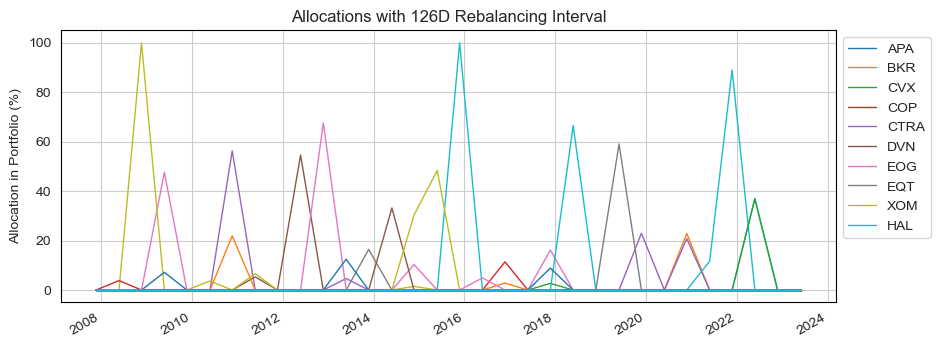

In [39]:
(ms_allocations  * 100).sample(100, axis=1, random_state=42).plot(
    legend=False, figsize=(10, 4)
)
plt.title(f"Allocations with {forecast}D Rebalancing Interval")
plt.ylabel("Allocation in Portfolio (%)")
plt.legend(ms_allocations.columns[:10], bbox_to_anchor=(1, 1))
plt.show()

In [40]:
ms_allocations.to_csv("workflow/data/ms_allocations.csv")
mv_allocations.to_csv("workflow/data/mv_allocations.csv")
rp_allocations.to_csv("workflow/data/rp_allocations.csv")

In [43]:
model_occurence.to_csv("workflow/data/model_occurence.csv")